<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задание-1" data-toc-modified-id="Задание-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задание 1</a></span></li><li><span><a href="#Задача-2" data-toc-modified-id="Задача-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Задача 2</a></span></li><li><span><a href="#Задача-3" data-toc-modified-id="Задача-3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Задача 3</a></span><ul class="toc-item"><li><span><a href="#Выгрузка-агрегата-для-анализа-эффективности-продлений-курсов" data-toc-modified-id="Выгрузка-агрегата-для-анализа-эффективности-продлений-курсов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выгрузка агрегата для анализа эффективности продлений курсов</a></span></li><li><span><a href="#Выгрузка-агрегата-для-отбора-учеников-не-продливших-курс" data-toc-modified-id="Выгрузка-агрегата-для-отбора-учеников-не-продливших-курс-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Выгрузка агрегата для отбора учеников не продливших курс</a></span></li></ul></li></ul></div>

# Тестовое задание ЕГЭLand

### Задание 1  

Результат SQL-скрипт в формате файла .sql: https://disk.yandex.ru/d/hnuLniy1tlIqGg

Выгрузить из базы данных с использованием SQL-запроса информацию по следующим пользователям:
        • Ученики с годовых курсов ЕГЭ и ОГЭ
    
    Необходимые поля в итоговой выгрузке:
        • ID курса
        • Название курса
        • Предмет
        • Тип предмета
        • Тип курса
        • Дата старта курса
        • ID ученика
        • Фамилия ученика
        • Город ученика
        • Ученик не отчислен с курса
        • Дата открытия курса ученику
        • Сколько полных месяцев курса открыто у ученика
        • Число сданных ДЗ ученика на курсе


In [1]:
# Установим необходимые библиотеки
!pip install sweetviz
!pip install duckdb duckdb-engine

In [2]:
# Импорт библиотек
import pandas as pd
import duckdb
import numpy as np
from datetime import datetime
from datetime import timedelta
import sweetviz as sv
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Задание таблиц БД
users = pd.read_csv('users.csv')
course_users = pd.read_csv('course_users.csv')
courses = pd.read_csv('courses.csv')
course_types = pd.read_csv('course_types.csv')
lessons = pd.read_csv('lessons.csv')
subjects = pd.read_csv('subjects.csv')
cities = pd.read_csv('cities.csv')
homework_done = pd.read_csv('homework_done.csv')
homework = pd.read_csv('homework.csv')
homework_lessons = pd.read_csv('homework_lessons.csv')
user_roles = pd.read_csv('user_roles.csv') 

In [4]:
# Задание SQL-запроса
query = """
/*отдельно в СТЕ считаю количество сделанных домашних заданий, 
 * чтобы не тащить эти джойны в итоговую таблицу*/
with homework_count as (
    Select 
        hd.user_id,
        cu.course_id,
        count(distinct hd.homework_id) as count_homework_done
    from homework_done hd
    left join homework_lessons hl on hl.homework_id = hd.homework_id
    left join lessons l on l.id = hl.lesson_id
    left join course_users cu on cu.user_id = hd.user_id and l.course_id = cu.course_id
    group by hd.user_id, cu.course_id 
)  

/*строю итоговую таблицу*/
Select --отбираем нужные столбцы и переименовываем
       cu.course_id, 
       c.name as name_courses, 
       sub.name as name_subjects, 
       sub.project as type_subjects,
       /*нужны только годовые курсы, поэтому сразу пропишем тип, 
        * чтобы не джойнить лишнюю таблицу*/
       'Годовой' as type_courses, 
       c.starts_at as start_date, 
       cu.user_id, 
       us.last_name, 
       ci.name as city_name,
       cu.active, 
       /*из схемы не понятно, какая дата отвечает 
       за открытие курса, выбрал наиболее подходящую дату по логике,
        где обновляется число открытых уроков*/
       cu.updated_at as date_opening,
       /*считаю количество открытых месяцев исходя из количества открытых уроков пользователя
        * и количества уровок на курсе и округляю до целого вниз*/
       coalesce(floor(available_lessons/lessons_in_month), 0) as full_available_month,  
       /*из СТЕ добавляем количество сделанных домашних заданий*/
       coalesce(hc.count_homework_done, 0) AS total_homework_done 

From users us 
/*джоины таблиц по схеме БД*/
left join course_users cu on us.id = cu.user_id
left join courses c on cu.course_id = c.id
left join subjects sub on sub.id = c.subject_id 
left join cities ci on ci.id = us.city_id
/*из СТЕ джоним количество сделанных домашних*/
left join homework_count hc ON hc.user_id = cu.user_id AND hc.course_id = cu.course_id 
/*далее отбор не пустых user id, типов курсов - годовые, 
 * типов предметов - ЕГЭ/ОГЭ, а также юзера с типом роли - студент*/
where us.id is not null
and c.course_type_id in (select course_types.id
                          from course_types 
                          where name ilike 'Годовой%')
and sub.project in ('ЕГЭ', 'ОГЭ')
and us.user_role_id in (select user_roles.id
                    from user_roles
                    where name = 'student')
"""
# Выполнение SQL-запроса
df_result = duckdb.query(query).to_df()
# Вывод результата
display(df_result.sort_values(by=['user_id','name_courses']).head(5))
df_result.shape

,course_id,name_courses,name_subjects,type_subjects,type_courses,start_date,user_id,last_name,city_name,active,date_opening,full_available_month,total_homework_done
537,24,В погоне за пятеркой 2К25 стандарт,Математика (база),ЕГЭ,Годовой,2024-09-17,10001,Markova,Самара,1,2024-10-22 17:08:03,2.0,3
641,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,10001,Markova,Самара,1,2024-10-16 15:21:34,2.0,10
2304,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10001,Markova,Самара,1,2024-10-22 17:06:53,2.0,9
1954,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10002,Коваленко,Москва,0,2024-10-30 18:20:50,1.0,5
2196,17,Годовой 2к25 стандарт,Английский язык,ЕГЭ,Годовой,2024-09-20,10003,Драгомирецкий,None,1,2024-10-02 07:48:59,0.0,2


(5881, 13)

### Задача 2


    С использованием python-скриптов обработать датасет, подготовленный в Задаче 1:
    
    1. Проверить датасет на: дубликаты, пропуски, типы данных, аномальные значения. 
    Произвести предобработку датасета, если это необходимо
    
    2. Поделить всех учеников на волны
    Критерии волн:
        • 0 волна – присоединились на курс до даты старта курса включительно
        • 1 волна - присоединились на курс в течение 1 недели после даты старта курса включительно
        • 2 волна - присоединились на курс в течение от 1 до 2 недель включительно после даты старта курса
        • 3 волна - присоединились на курс в течение от 2 до 3 недель включительно после даты старта курса
        • 4 волна - присоединились на курс в течение от 3 до 4 недель включительно после даты старта курса
        • 5 волна - присоединились на курс от 4 недель после даты старта курса

In [5]:
df_result.head()

,course_id,name_courses,name_subjects,type_subjects,type_courses,start_date,user_id,last_name,city_name,active,date_opening,full_available_month,total_homework_done
0,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10022,Ролдугина,Донецк,1,2024-10-24 20:48:09,2.0,14
1,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,10032,Тайгозина,Йошкар-Ола,1,2024-10-11 05:03:47,2.0,13
2,38,Годовой курс 2к25,Математика ОГЭ,ОГЭ,Годовой,2024-09-23,10068,Боженова,Коркино,1,2024-10-21 17:25:59,2.0,14
3,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10079,Искандарова,Пермь,1,2024-10-14 15:22:28,2.0,14
4,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10094,Солнышко,Москва,1,2024-10-14 16:33:24,9.0,10


In [6]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   course_id             5881 non-null   int64  
 1   name_courses          5881 non-null   object 
 2   name_subjects         5881 non-null   object 
 3   type_subjects         5881 non-null   object 
 4   type_courses          5881 non-null   object 
 5   start_date            5881 non-null   object 
 6   user_id               5881 non-null   int64  
 7   last_name             5881 non-null   object 
 8   city_name             5540 non-null   object 
 9   active                5881 non-null   int64  
 10  date_opening          5881 non-null   object 
 11  full_available_month  5881 non-null   float64
 12  total_homework_done   5881 non-null   int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 597.4+ KB


В основном типы данных корректные, за исключение колонок с датами и full_available_month к целочисленному

In [7]:
# Преобразуем столбцы с датами и full_available_month
df_result['start_date'] = pd.to_datetime(df_result['start_date'], errors='coerce')
df_result['date_opening'] = pd.to_datetime(df_result['date_opening'], errors='coerce')
df_result['date_opening'] = df_result['date_opening'].dt.date 
df_result['date_opening'] = pd.to_datetime(df_result['date_opening'], errors='coerce')
df_result['full_available_month'] = df_result['full_available_month'].astype(int)

In [8]:
# Проверим пропуски
df_result.isnull().sum()

course_id                 0
name_courses              0
name_subjects             0
type_subjects             0
type_courses              0
start_date                0
user_id                   0
last_name                 0
city_name               341
active                    0
date_opening              0
full_available_month      0
total_homework_done       0
dtype: int64

Пропуски только в названиях городов, основные пропуски были исключены на этапе Задания 1, там где были nan в user id - их исключили.
Пропуски только в названиях городов заполним - "нет данных"

In [9]:
df_result['city_name'] = df_result['city_name'].fillna('нет данных')

In [10]:
# Проверим на явные дубликаты
print('Явных дубликатов:', df_result.duplicated().sum())

Явных дубликатов: 0


In [11]:
# Добавляю колонку с расчетом разницы в днях между date_opening и start_date 
df_result['days_diff'] = (df_result['date_opening'] - df_result['start_date']).dt.days

# Функция для проставления признака волны на основе days_diff
def determine_wave(days_diff):
    if days_diff <= 0:
        return '0 волна'
    elif 0 < days_diff <= 7:
        return '1 волна'
    elif 7 < days_diff <= 14:
        return '2 волна'
    elif 14 < days_diff <= 21:
        return '3 волна'
    elif 21 < days_diff <= 28:
        return '4 волна'
    else:
        return '5 волна'

# Создаем новую колонку 'wave' 
df_result['wave'] = df_result['days_diff'].apply(determine_wave)

# Удаляю промежуточную колонку 'days_diff'
df_result = df_result.drop(columns='days_diff')

In [12]:
df_result.wave.unique()

array(['5 волна', '4 волна', '3 волна', '0 волна', '2 волна', '1 волна'],
      dtype=object)

Посмотрим на распределения основных признаков с помощью библиотеки sweetviz

                                             |                                             | [  0%]   00:00 ->…


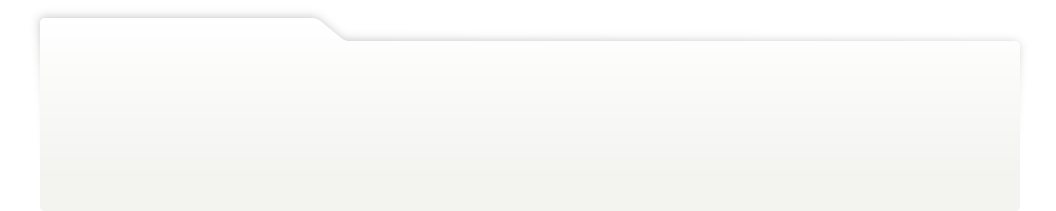
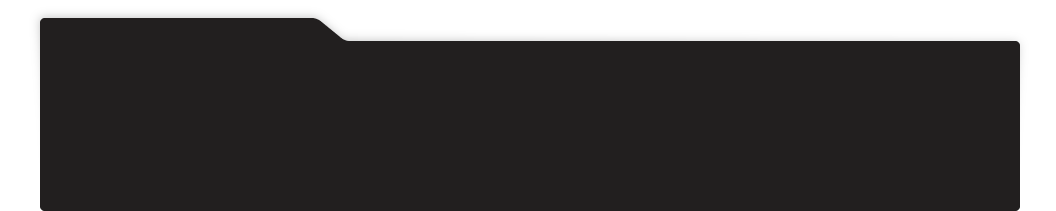
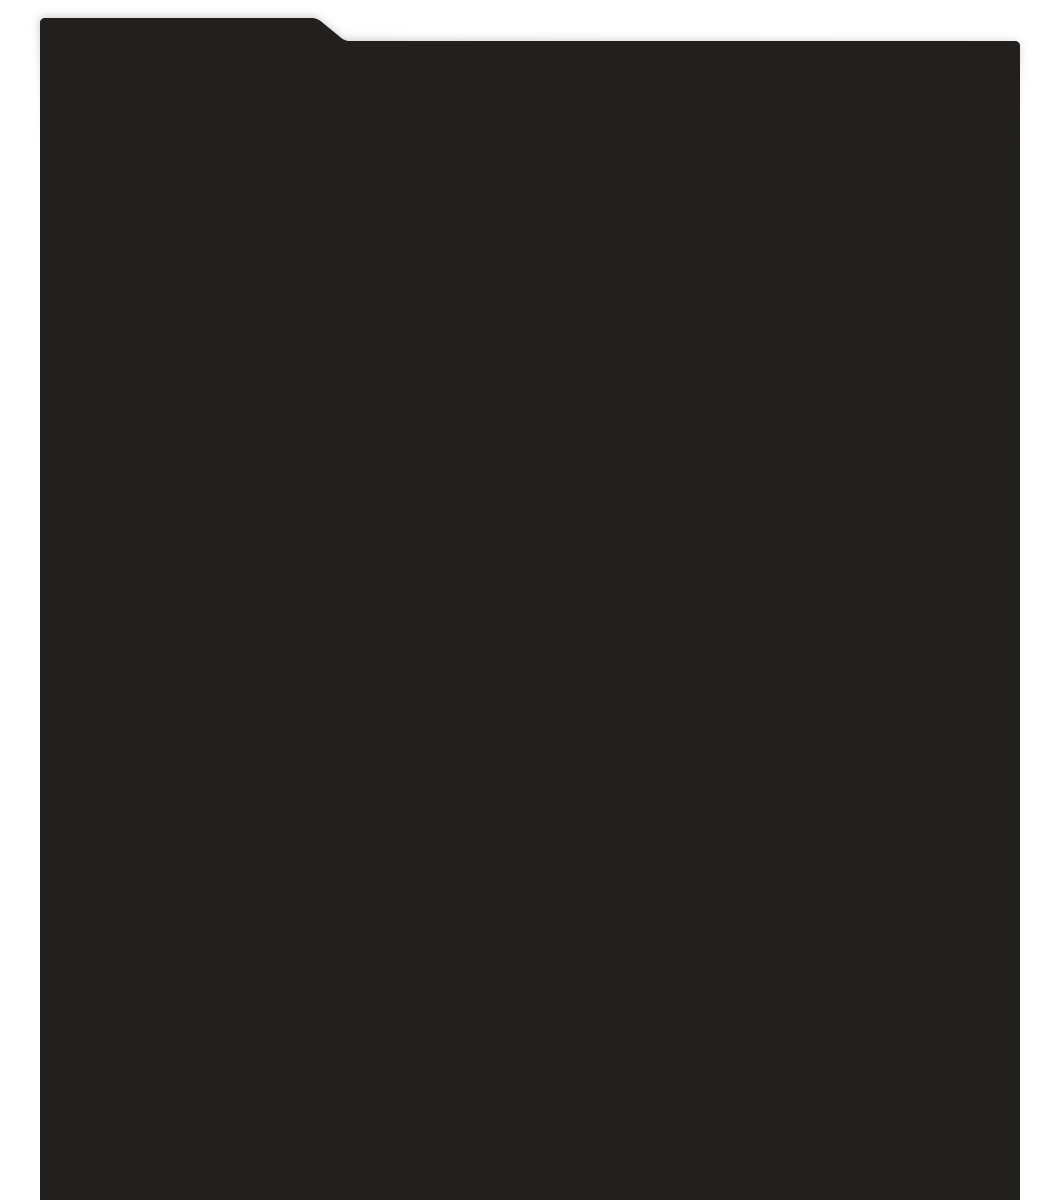
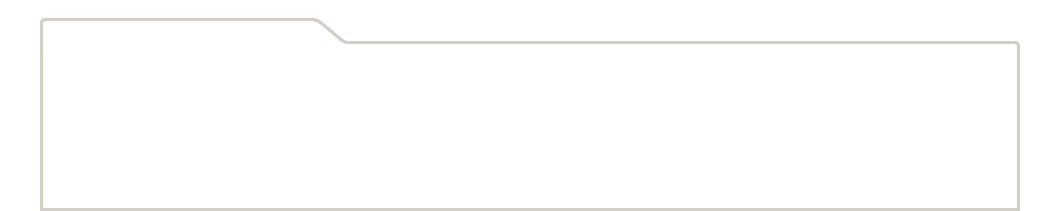
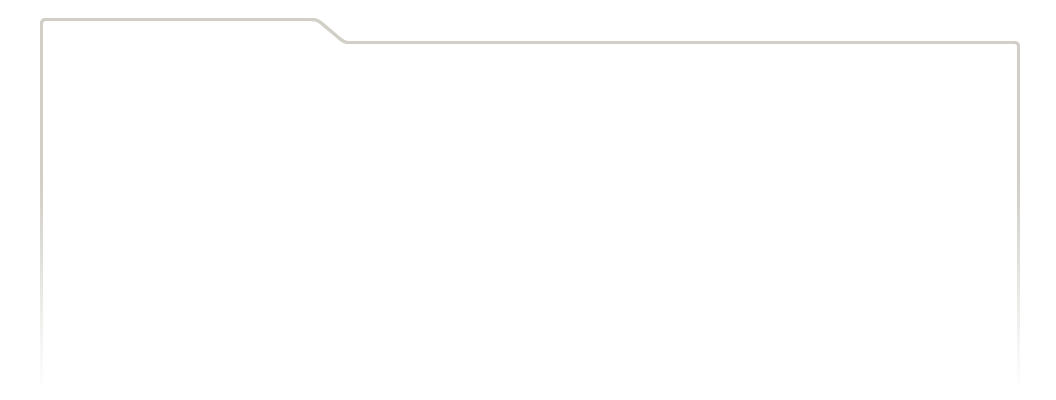
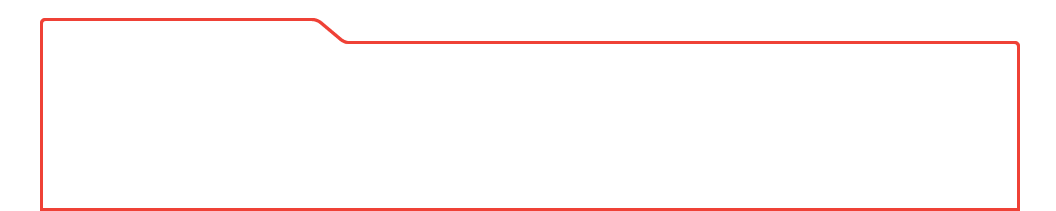
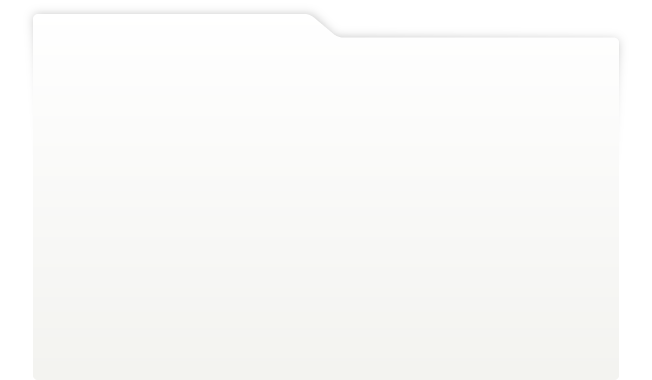
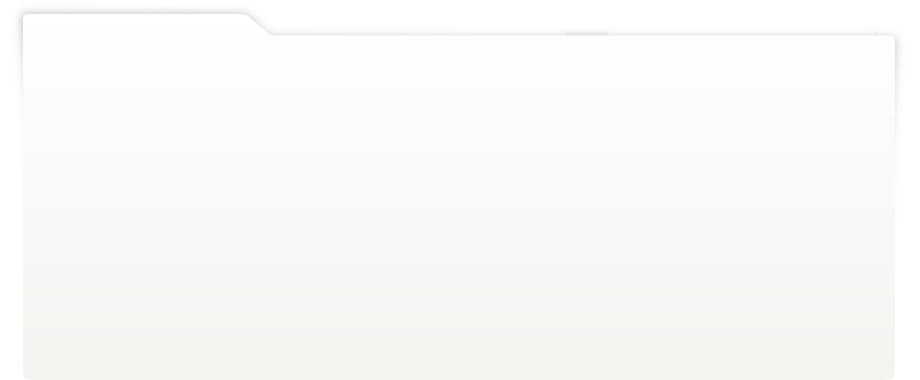
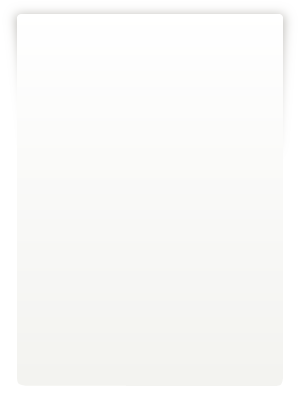
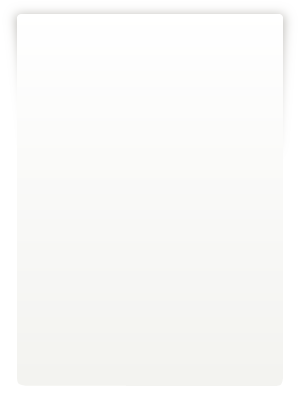
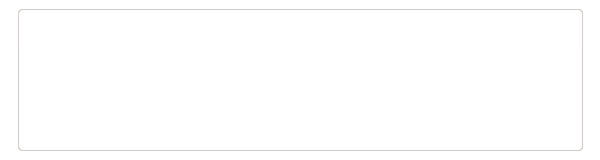
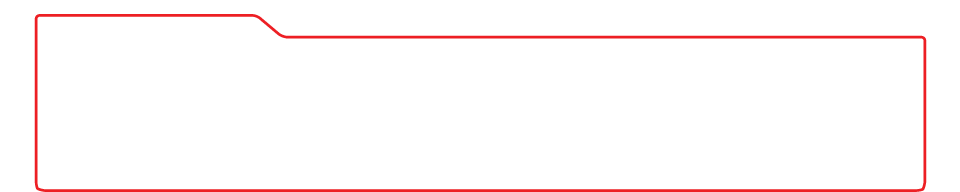
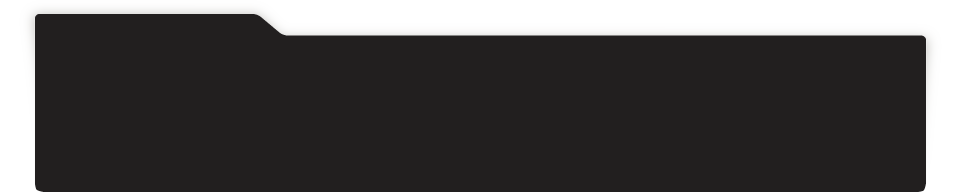
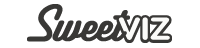
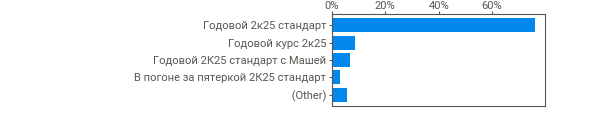
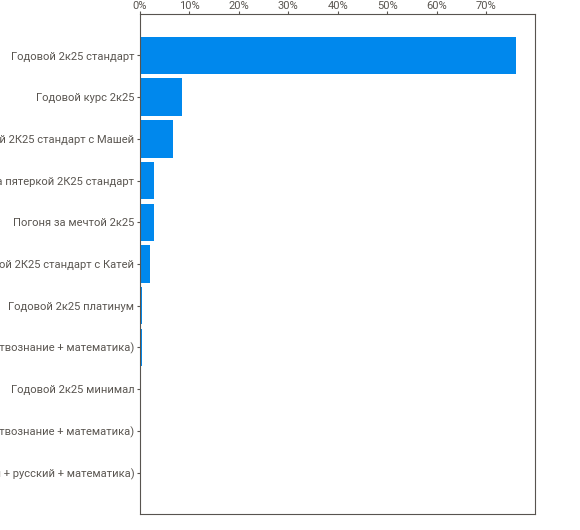
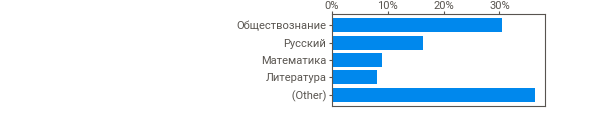
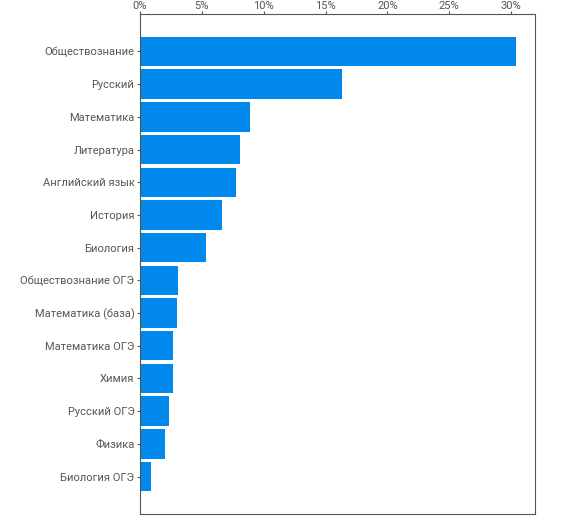
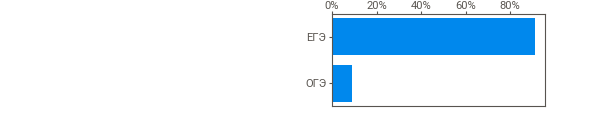
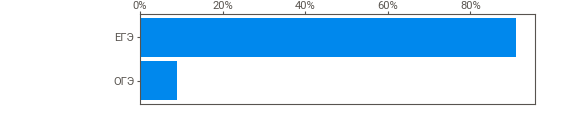
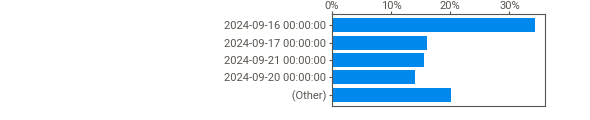
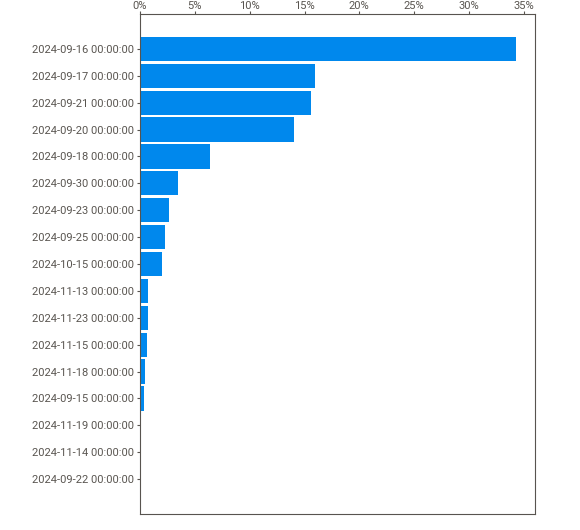
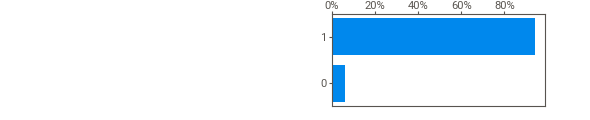
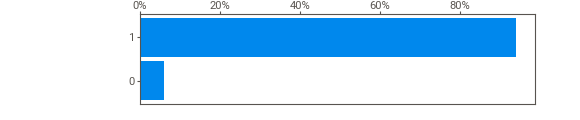
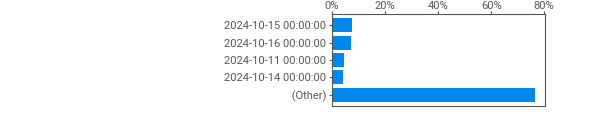
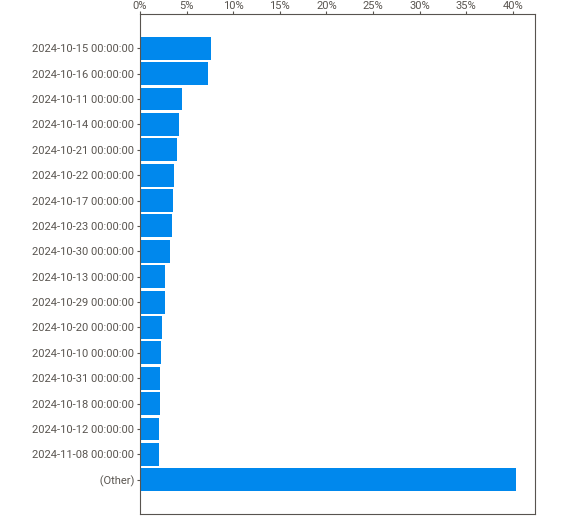
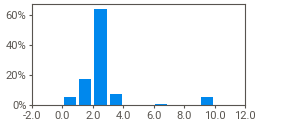
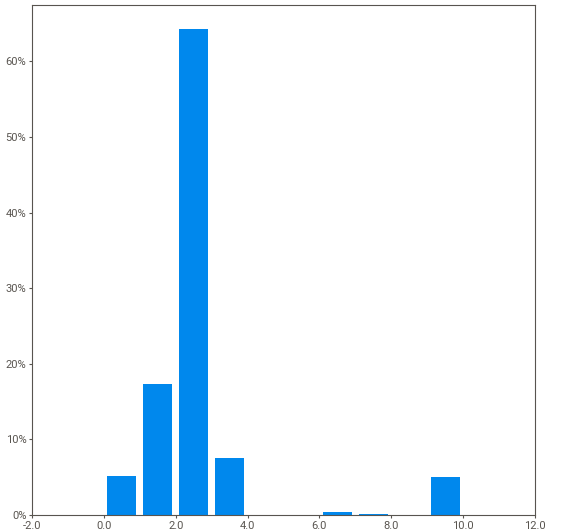
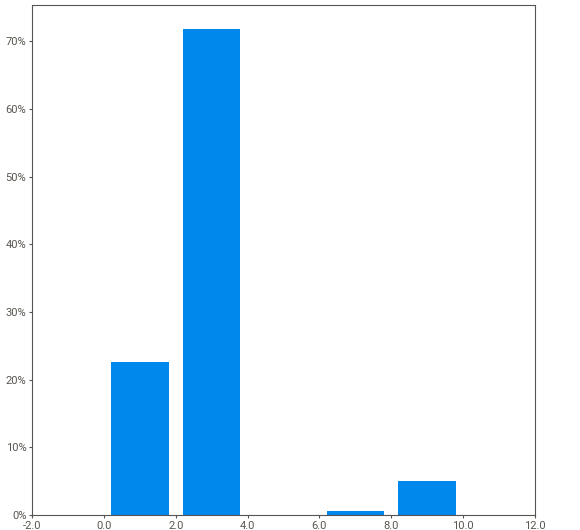
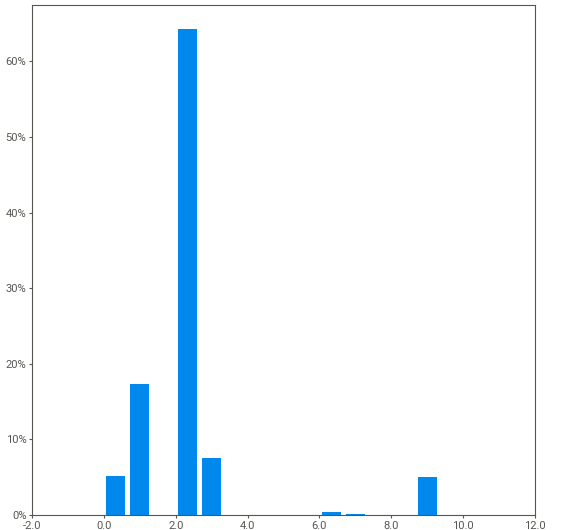
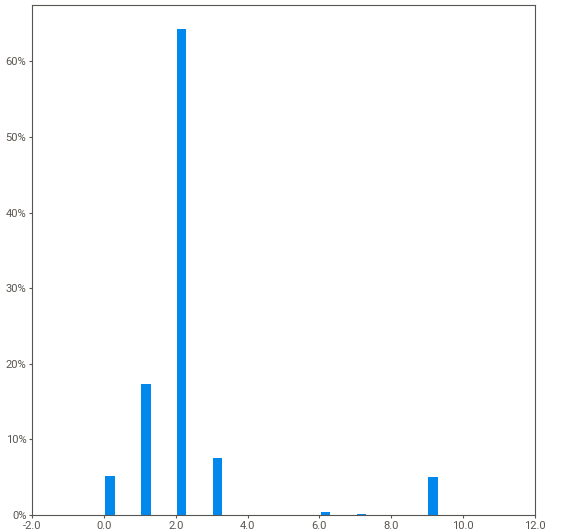
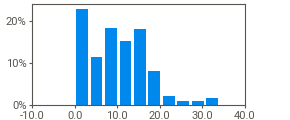
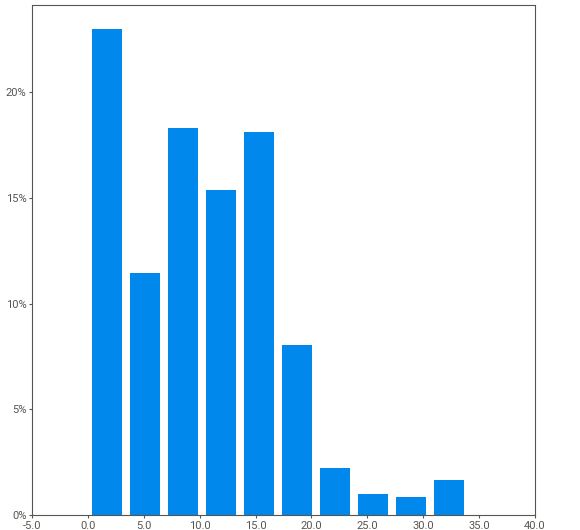
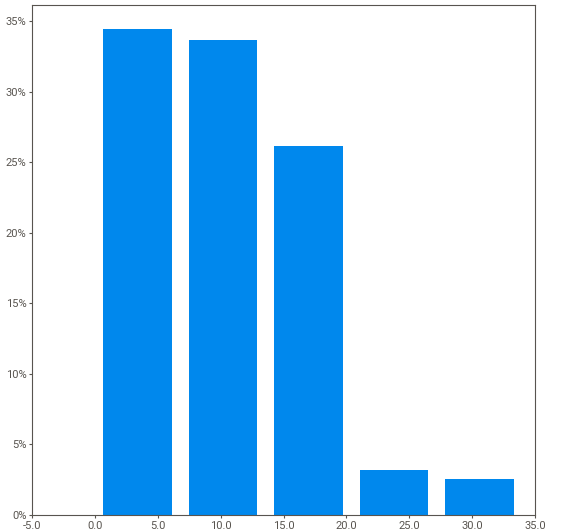
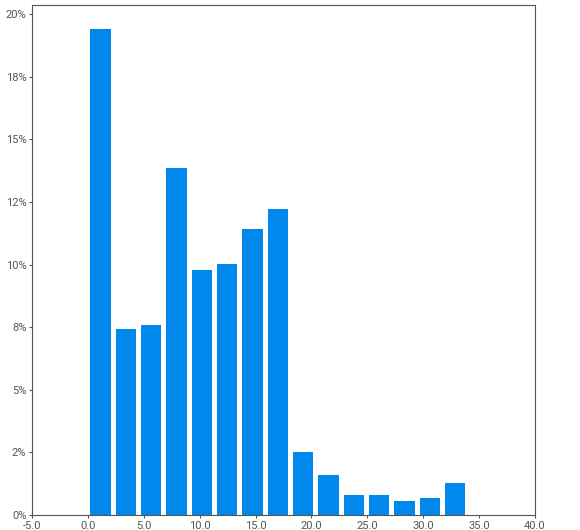
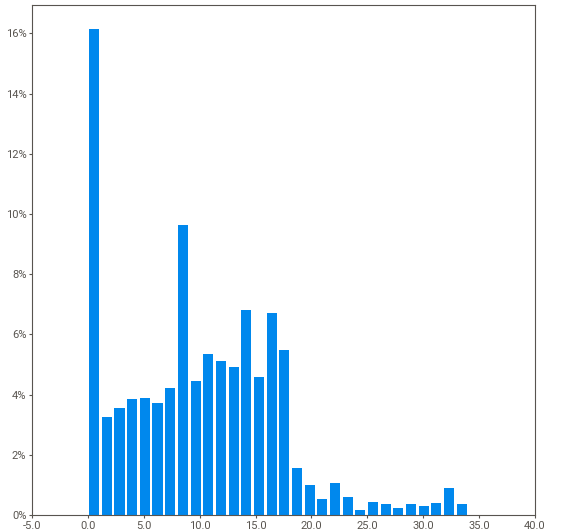
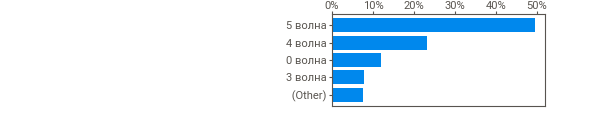
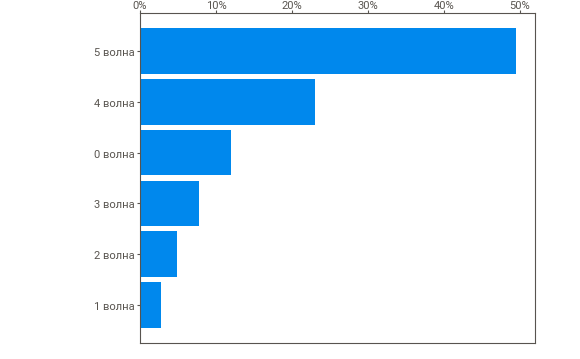
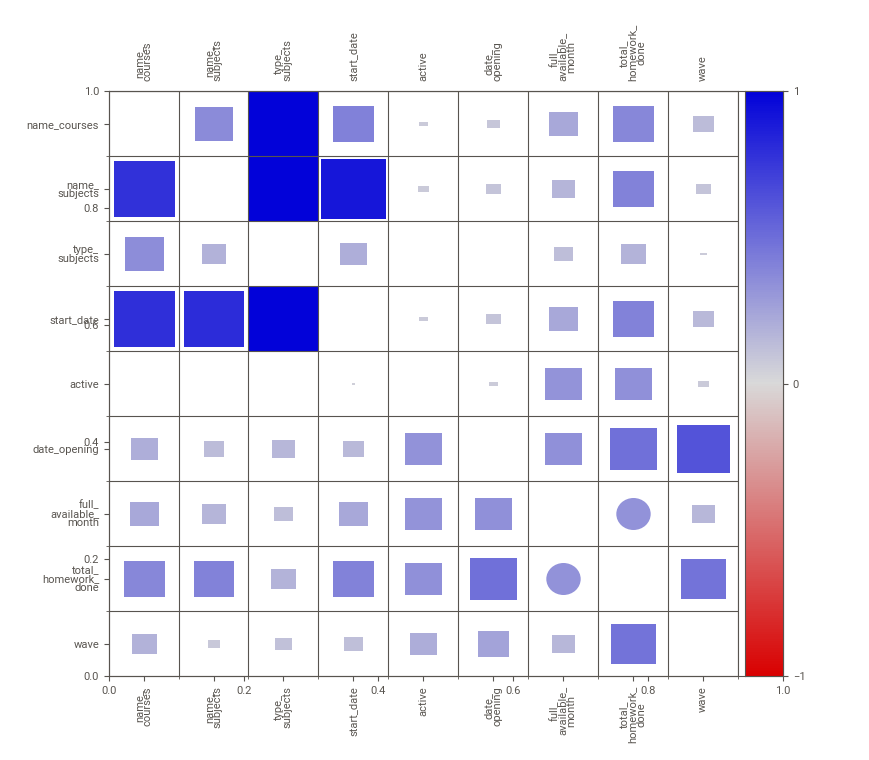
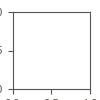

In [13]:
#  Отберем колонки для анализа
columns_to_analyze = ['name_courses', 'name_subjects', 'type_subjects', 'start_date',
                      'city_name', 'active', 'date_opening', 'full_available_month', 'total_homework_done', 'wave']
# Отчета Sweetviz по df_result
report_df_result = sv.analyze(df_result[columns_to_analyze])
# Вывод отчета
report_df_result.show_notebook()

Краткий вывывод:
            
            - 76% от всего количества курсов занимает "Годовой 2к25 стандарт"
             - Наиболее част изучаемы предметы: Обществознание, русский, математика
             - 91% от учащихся, готовится к ЕГЭ
             - основная дата старта курсов - 16.09.2024 по 20.09.2024
             - Лидер по количеству студентов - Москва -14%
             - активных - 94%
             - наибольшая доля открытия уроков (7-8%) пришлось на 16.10-17.10.2024
             - чаще всего оплачивают за 2 месяца 64%, реже за 1 17%, за 3 месяца - 7.5%, но 5% пользователей оплатили за 9 месяцев.
             - в среднем выполнено 10 домашних заданий, 75% выполнило до 15 заданий.
             - самые массовые - 5-я и 4-я волны, 50% и 23% соответственно, 0-я волна на 3-м месте.
            

### Задача 3

Построить дашборд в Yandex DataLens с использованием датасета, подготовленного в Задаче 2.
Ссылка на дашборд: https://datalens.yandex/m2l67hxm3e1q9

 Цель 1. Отслеживать какие курсы хуже всего /лучше всего продлеваются учениками
        1. Сравнивать курсы по двум метрикам: числу и проценту продлений заданного месяца. 
        Пример: на заданном курсе всего 1000 учеников, из них продлили 2-й месяц курса 800 учеников. Тогда на
данном курсе: число продлений 2-го месяца равно 800, процент продлений 2-го месяца равен 80%
 
 Цель 2. Отбирать учеников, которые не продлили курс, по дополнительным заданным критериям, чтобы
связываться с данными учениками для повышения процента продлений
    2. Получать полную информацию по ученикам (курс ученика, волна ученика на курсе, число сданных
ДЗ ученика на курсе, город ученика и т.д.), которые подходят под данное условие:
    a. Не отчислены с курса
    Также должна быть возможность среди данных учеников отобрать учеников:
    b. С заданных курсов
    c. С заданных волн
    d. С заданных городов
    e. Которые не продлили заданный месяц курса
    f. У которых число сданных ДЗ на курсе меньше заданного числа

#### Выгрузка агрегата для анализа эффективности продлений курсов

    Для реалиpации на дашборде информации о курсах и проценте продлений сделаю агрегат в котором будет информация:
            - название курса
            - месяц
            - количество учеников курска
            - количество учеников продливших курс
            - процент продливших курс

In [14]:
# Cчитаем общее количество пользователей для каждого курса
total_users_per_course = df_result.query('active == 1').groupby('course_id')['user_id'].nunique().reset_index()
total_users_per_course.columns = ['course_id', 'total_users']
total_users_per_course

# Датасет с номерами месяцев для каждого курса от 1 до 12
months = pd.DataFrame({'month': range(1, 13)})

# Расчет количества продлений для каждого месяца и курса
result = (
    df_result
    .query('active == 1')
    .merge(months, how='cross')
    .query('full_available_month >= month')  
    .groupby(['course_id', 'month'])
    .agg(
        user_renewals=('user_id', 'nunique') 
    )
    .reset_index()
)

# Мердж total_users и процент продлений
result = result.merge(total_users_per_course, on='course_id', how='left')
# Мердж названия курса и группировка и расчет процентов
result = result.merge(df_result[['course_id', 'name_courses']].drop_duplicates(), how='left', on='course_id')
result = result.groupby(['name_courses', 'month']).agg({'total_users':'sum', 'user_renewals': 'sum'}).reset_index()
result['renew_percentage'] = round(((result['user_renewals'] / result['total_users']) * 100), 1)
result = result[['name_courses', 'month', 'total_users', 'user_renewals', 'renew_percentage']]
result.head()

,name_courses,month,total_users,user_renewals,renew_percentage
0,В погоне за пятеркой 2К25 стандарт,1,156,156,100.0
1,В погоне за пятеркой 2К25 стандарт,2,156,104,66.7
2,В погоне за пятеркой 2К25 стандарт,3,156,33,21.2
3,Годовой 2К25 стандарт с Катей,1,97,96,99.0
4,Годовой 2К25 стандарт с Катей,2,97,12,12.4


In [15]:
#Gосмотрим на меры централной тенденции
result.groupby('month')['renew_percentage'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,9.0,93.455556,19.261173,42.1,100.000,100.00,100.00,100.0
2,8.0,64.325000,35.183631,6.9,53.125,76.90,87.00,100.0
3,7.0,11.214286,7.199173,2.1,4.900,14.20,15.60,21.2
4,6.0,5.783333,3.539162,1.0,3.750,5.35,8.30,10.5
5,6.0,5.783333,3.539162,1.0,3.750,5.35,8.30,10.5
6,6.0,5.716667,3.483915,1.0,3.750,5.30,8.05,10.5
7,6.0,5.533333,3.565202,1.0,3.225,5.10,7.95,10.5
8,5.0,5.740000,3.882396,1.0,2.900,5.90,8.40,10.5
9,5.0,5.740000,3.882396,1.0,2.900,5.90,8.40,10.5


In [16]:
# выгружаем в csv для загрузки в datdlens
#result.to_csv('result.csv', index=False, encoding='utf-8')

#### Выгрузка агрегата для отбора учеников не продливших курс

    Для реалиpации на дашборде информации о курсах и проценте продлений сделаю агрегат, в котором будет следующая информация
    по ученикам со статусом активен:
            - id ученика
            - имя ученика
            - название курса
            - название предмета
            - волна
            - город
            - количество сданных ДЗ
            - количество продленных месяцев

In [17]:
users_active = df_result[['user_id', 'last_name', 'city_name', 'name_courses',
                          'name_subjects', 'wave', 'active', 'total_homework_done', 'full_available_month']].query('active == 1')
users_active

,user_id,last_name,city_name,name_courses,name_subjects,wave,active,total_homework_done,full_available_month
0,10022,Ролдугина,Донецк,Годовой 2к25 стандарт,Русский,5 волна,1,14,2
1,10032,Тайгозина,Йошкар-Ола,Годовой 2к25 стандарт,Обществознание,4 волна,1,13,2
2,10068,Боженова,Коркино,Годовой курс 2к25,Математика ОГЭ,4 волна,1,14,2
3,10079,Искандарова,Пермь,Годовой 2к25 стандарт,Русский,4 волна,1,14,2
4,10094,Солнышко,Москва,Годовой 2к25 стандарт,Русский,4 волна,1,10,9
...,...,...,...,...,...,...,...,...,...
5875,30392,Симакова,Чебоксары,Годовой 2К25 стандарт с Катей,Математика,0 волна,1,0,1
5877,30740,Александровна,Белово,В погоне за пятеркой 2К25 стандарт,Математика (база),3 волна,1,0,1
5878,33265,Толчева,Санкт-Петербург,Погоня за мечтой 2к25,Английский язык,0 волна,1,0,1
5879,30753,Didicheva,Майкоп,Погоня за мечтой 2к25,Обществознание,0 волна,1,0,1


In [18]:
# выгружаем в csv для загрузки в datdlens
#users_active.to_csv('users_active.csv', index=False, encoding='utf-8')